# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.neighbors import DistanceMetric
from math import radians

# Load Data

### Data Source:
https://www.kaggle.com/datasets/yasserh/uber-fares-dataset

In [2]:
fare_data = pd.read_csv('/kaggle/input/uber-fares-dataset/uber.csv')

Problem Statement:

The project is about on world's largest taxi company Uber inc. In this project, we're looking to predict the fare for their future transactional cases. Uber delivers service to lakhs of customers daily. Now it becomes really important to manage their data properly to come up with new business ideas to get best results. Eventually, it becomes really important to estimate the fare prices accurately.

In [3]:
fare_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Unnamed: 0         200000 non-null  int64  
 1   key                200000 non-null  object 
 2   fare_amount        200000 non-null  float64
 3   pickup_datetime    200000 non-null  object 
 4   pickup_longitude   200000 non-null  float64
 5   pickup_latitude    200000 non-null  float64
 6   dropoff_longitude  199999 non-null  float64
 7   dropoff_latitude   199999 non-null  float64
 8   passenger_count    200000 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 13.7+ MB


In [4]:
fare_data.head()

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


Only two column with missing data, i.e, dropoff_longitude and dropoff_latitude

Mix of numerical and categorical variables:
- Numerical Variables:
    - pickup_datetime
    - pickup_latitude
    - pickup_longitude
    - dropoff_latitude
    - dropoff_longitude
- Categorical Variables:
    - passanger_count

Target variable is fare_amount

In [5]:
data = fare_data

In [6]:
data.nunique()

Unnamed: 0           200000
key                  200000
fare_amount            1244
pickup_datetime      196629
pickup_longitude      71066
pickup_latitude       83835
dropoff_longitude     76894
dropoff_latitude      90585
passenger_count           8
dtype: int64

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Unnamed: 0         200000 non-null  int64  
 1   key                200000 non-null  object 
 2   fare_amount        200000 non-null  float64
 3   pickup_datetime    200000 non-null  object 
 4   pickup_longitude   200000 non-null  float64
 5   pickup_latitude    200000 non-null  float64
 6   dropoff_longitude  199999 non-null  float64
 7   dropoff_latitude   199999 non-null  float64
 8   passenger_count    200000 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 13.7+ MB


dropoff_longitude and dropoff_latitude have one missing row. We need to exclude this

In [8]:
data.nunique()

Unnamed: 0           200000
key                  200000
fare_amount            1244
pickup_datetime      196629
pickup_longitude      71066
pickup_latitude       83835
dropoff_longitude     76894
dropoff_latitude      90585
passenger_count           8
dtype: int64

In [9]:
# Dropping the columns 'Unnamed: 0' and 'key' as well as NA rows

data = data.drop(['Unnamed: 0','key'],axis=1) 
data.dropna(axis=0,inplace=True)

# Exploratory Data Analysis (EDA) and Data Pre-processing

In [10]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
fare_amount,199999.0,11.359892,9.901760,-52.000000,6.000000,8.500000,12.500000,499.000000
pickup_longitude,199999.0,-72.527631,11.437815,-1340.648410,-73.992065,-73.981823,-73.967154,57.418457
pickup_latitude,199999.0,39.935881,7.720558,-74.015515,40.734796,40.752592,40.767158,1644.421482
dropoff_longitude,199999.0,-72.525292,13.117408,-3356.666300,-73.991407,-73.980093,-73.963658,1153.572603
dropoff_latitude,199999.0,39.923890,6.794829,-881.985513,40.733823,40.753042,40.768001,872.697628
passenger_count,199999.0,1.684543,1.385995,0.000000,1.000000,1.000000,2.000000,208.000000


Possibility of some outliers in fare amount and passanger

Outliers:
- Fare Amount is between -52 to 499. The negative amount seems unrealistic. Base fare to be set at $2.5
- Passanger count max is 208, which is also not possible. Max to be set at 5

### Identifying Correlations

In [11]:
# Identify Correlation
data.corr()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
fare_amount,1.000000,0.010458,-0.008482,0.008986,-0.011014,0.010158
pickup_longitude,0.010458,1.000000,-0.816461,0.833026,-0.846324,-0.000415
pickup_latitude,-0.008482,-0.816461,1.000000,-0.774787,0.702367,-0.001559
dropoff_longitude,0.008986,0.833026,-0.774787,1.000000,-0.917010,0.000033
dropoff_latitude,-0.011014,-0.846324,0.702367,-0.917010,1.000000,-0.000659
passenger_count,0.010158,-0.000415,-0.001559,0.000033,-0.000659,1.000000


<AxesSubplot:>

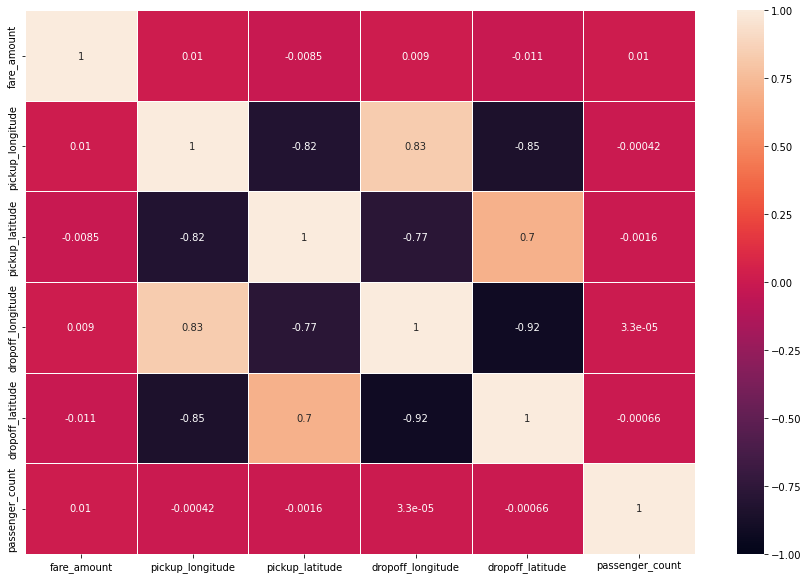

In [12]:
# Plot the Correlation matrix
plt.figure(figsize=(15,10))
sns.heatmap(data.corr(), annot=True, linewidths=.5, vmin = -1, vmax = 1, fmt = '.2g')

High correlation can be observed between the geo-spatial data points, which was expected. Therefore, there is no need to drop any of the independent variables

In [13]:
from math import *

In [14]:
# Define formula to calculate haversine distance
def distance(longitude1, latitude1, longitude2, latitude2):
    travel_dist = []
    
    for pos in range(len(longitude1)):
        long1,lati1,long2,lati2 = map(radians,[longitude1[pos],latitude1[pos],longitude2[pos],latitude2[pos]])
        dist_long = long2 - long1
        dist_lati = lati2 - lati1
        a = sin(dist_lati/2)**2 + cos(lati1) * cos(lati2) * sin(dist_long/2)**2
        c = 2 * asin(sqrt(a))*6371
        travel_dist.append(c)
       
    return travel_dist

In [15]:
# Calculate Haversine distance for each row and add distance in km as a new column
data['distance_travelled'] = distance(data['pickup_longitude'].to_numpy(),
                                                data['pickup_latitude'].to_numpy(),
                                                data['dropoff_longitude'].to_numpy(),
                                                data['dropoff_latitude'].to_numpy()
                                              )

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 199999 entries, 0 to 199999
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   fare_amount         199999 non-null  float64
 1   pickup_datetime     199999 non-null  object 
 2   pickup_longitude    199999 non-null  float64
 3   pickup_latitude     199999 non-null  float64
 4   dropoff_longitude   199999 non-null  float64
 5   dropoff_latitude    199999 non-null  float64
 6   passenger_count     199999 non-null  int64  
 7   distance_travelled  199999 non-null  float64
dtypes: float64(6), int64(1), object(1)
memory usage: 13.7+ MB


In [17]:
# As we can see, pickup_datetime is being read as an object data type. However, we need to convert it into datetime data type
data['pickup_datetime']  = pd.to_datetime(data['pickup_datetime'])

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 199999 entries, 0 to 199999
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype              
---  ------              --------------   -----              
 0   fare_amount         199999 non-null  float64            
 1   pickup_datetime     199999 non-null  datetime64[ns, UTC]
 2   pickup_longitude    199999 non-null  float64            
 3   pickup_latitude     199999 non-null  float64            
 4   dropoff_longitude   199999 non-null  float64            
 5   dropoff_latitude    199999 non-null  float64            
 6   passenger_count     199999 non-null  int64              
 7   distance_travelled  199999 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(6), int64(1)
memory usage: 13.7 MB


In [19]:
data['fare_per_km']=data['fare_amount']/data['distance_travelled']

In [20]:
data.head(50)

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance_travelled,fare_per_km
0,7.5,2015-05-07 19:52:06+00:00,-73.999817,40.738354,-73.999512,40.723217,1,1.683323,4.455474
1,7.7,2009-07-17 20:04:56+00:00,-73.994355,40.728225,-73.994710,40.750325,1,2.457590,3.133151
2,12.9,2009-08-24 21:45:00+00:00,-74.005043,40.740770,-73.962565,40.772647,1,5.036377,2.561365
3,5.3,2009-06-26 08:22:21+00:00,-73.976124,40.790844,-73.965316,40.803349,3,1.661683,3.189536
4,16.0,2014-08-28 17:47:00+00:00,-73.925023,40.744085,-73.973082,40.761247,5,4.475450,3.575060
5,4.9,2011-02-12 02:27:09+00:00,-73.969019,40.755910,-73.969019,40.755910,1,0.000000,inf
6,24.5,2014-10-12 07:04:00+00:00,-73.961447,40.693965,-73.871195,40.774297,5,11.731015,2.088481
7,2.5,2012-12-11 13:52:00+00:00,0.000000,0.000000,0.000000,0.000000,1,0.000000,inf
8,9.7,2012-02-17 09:32:00+00:00,-73.975187,40.745767,-74.002720,40.743537,1,2.332711,4.158252
9,12.5,2012-03-29 19:06:00+00:00,-74.001065,40.741787,-73.963040,40.775012,1,4.889417,2.556542


In [21]:
data.fare_per_km.max()

inf

In [22]:
# From pickup_datetime extract date, month, year, weekday and dayname
from datetime import datetime

data['date'] = pd.to_datetime(data['pickup_datetime']).dt.date
data['month'] = pd.to_datetime(data['pickup_datetime']).dt.month
data['year'] = pd.to_datetime(data['pickup_datetime']).dt.year
data['day_of_the_week'] = pd.to_datetime(data['pickup_datetime']).dt.weekday
data['day_name'] = pd.to_datetime(data['pickup_datetime']).dt.day_name()
data['pickup_time'] = pd.to_datetime(data['pickup_datetime']).dt.time
data['pickup_hour'] = pd.to_datetime(data['pickup_datetime']).dt.hour


In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 199999 entries, 0 to 199999
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype              
---  ------              --------------   -----              
 0   fare_amount         199999 non-null  float64            
 1   pickup_datetime     199999 non-null  datetime64[ns, UTC]
 2   pickup_longitude    199999 non-null  float64            
 3   pickup_latitude     199999 non-null  float64            
 4   dropoff_longitude   199999 non-null  float64            
 5   dropoff_latitude    199999 non-null  float64            
 6   passenger_count     199999 non-null  int64              
 7   distance_travelled  199999 non-null  float64            
 8   fare_per_km         199997 non-null  float64            
 9   date                199999 non-null  object             
 10  month               199999 non-null  int64              
 11  year                199999 non-null  int64              
 12  day_of_the_week 

### Outlier Treatment

The following treatment is being done to outliers:
- passanger_count should be less than 5
- rows with passanger_count = 0 should be dropped
- fare_amount should be kept to the minimum set by Uber, i.e., $2.5
- distance should be maximum 130 km
- distance travelled cannot be zero. Rows with distance = 0 must be dropped

In [24]:
data.drop(data[data['passenger_count'] > 5].index, axis=0, inplace = True)
data.drop(data[data['passenger_count'] == 0].index, axis=0, inplace = True)
data.drop(data[data['fare_amount'] < 2.5].index, axis=0, inplace = True)
data.drop(data[data['distance_travelled'] > 130].index, axis=0, inplace = True)
data.drop(data[data['distance_travelled'] == 0].index, axis=0, inplace = True)
data.drop(data[data['fare_per_km'] > 15 ].index, axis=0, inplace = True)
data.drop(data[data['fare_per_km'] < 1 ].index, axis=0, inplace = True)
data.dropna(axis=0,inplace=True)


In [25]:
data.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance_travelled,fare_per_km,date,month,year,day_of_the_week,day_name,pickup_time,pickup_hour
0,7.5,2015-05-07 19:52:06+00:00,-73.999817,40.738354,-73.999512,40.723217,1,1.683323,4.455474,2015-05-07,5,2015,3,Thursday,19:52:06,19
1,7.7,2009-07-17 20:04:56+00:00,-73.994355,40.728225,-73.994710,40.750325,1,2.457590,3.133151,2009-07-17,7,2009,4,Friday,20:04:56,20
2,12.9,2009-08-24 21:45:00+00:00,-74.005043,40.740770,-73.962565,40.772647,1,5.036377,2.561365,2009-08-24,8,2009,0,Monday,21:45:00,21
3,5.3,2009-06-26 08:22:21+00:00,-73.976124,40.790844,-73.965316,40.803349,3,1.661683,3.189536,2009-06-26,6,2009,4,Friday,08:22:21,8
4,16.0,2014-08-28 17:47:00+00:00,-73.925023,40.744085,-73.973082,40.761247,5,4.475450,3.575060,2014-08-28,8,2014,3,Thursday,17:47:00,17


In [26]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
fare_amount,185518.0,11.291555,9.405703,2.500000,6.000000,8.500000,12.500000,230.000000
pickup_longitude,185518.0,-73.924358,2.401748,-75.387785,-73.992287,-73.982172,-73.968599,40.806012
pickup_latitude,185518.0,40.700873,2.367045,-74.015515,40.736502,40.753274,40.767578,42.478467
dropoff_longitude,185518.0,-73.923311,2.401850,-75.417737,-73.991595,-73.980590,-73.965662,40.831932
dropoff_latitude,185518.0,40.701207,2.367362,-74.015750,40.735405,40.753758,40.768368,42.464187
passenger_count,185518.0,1.595015,1.150306,1.000000,1.000000,1.000000,2.000000,5.000000
distance_travelled,185518.0,3.387932,3.590524,0.167931,1.315546,2.210790,3.970801,60.851156
fare_per_km,185518.0,4.228687,1.850882,1.007472,2.957554,3.790655,4.963468,14.998885
month,185518.0,6.277359,3.439935,1.000000,3.000000,6.000000,9.000000,12.000000
year,185518.0,2011.724630,1.862175,2009.000000,2010.000000,2012.000000,2013.000000,2015.000000


In [27]:
# Dropping the columns 'pickup datetime' and 'pickup hour' as we have extracted relvant pieces of information
# from these columns and do not need these columns for our analysis now. Also, 'date' and 'day_name', month and yuear
# as well as pickup and dropoff coordinates are not required as we have the required data extracted from them

data = data.drop(['pickup_datetime','pickup_time', 'date', 'pickup_longitude', 'pickup_latitude',
                  'dropoff_longitude', 'dropoff_latitude', 'day_name'],axis=1)

In [28]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 185518 entries, 0 to 199999
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   fare_amount         185518 non-null  float64
 1   passenger_count     185518 non-null  int64  
 2   distance_travelled  185518 non-null  float64
 3   fare_per_km         185518 non-null  float64
 4   month               185518 non-null  int64  
 5   year                185518 non-null  int64  
 6   day_of_the_week     185518 non-null  int64  
 7   pickup_hour         185518 non-null  int64  
dtypes: float64(3), int64(5)
memory usage: 12.7 MB


# Numerical Features - Univariate Analysis

## Boxplot & Histogram

### Distance

<AxesSubplot:xlabel='distance_travelled'>

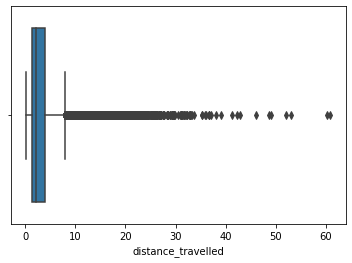

In [29]:
sns.boxplot(x=data['distance_travelled'])

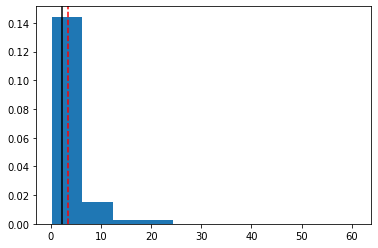

In [30]:
import matplotlib.pyplot as plt
hist = plt.hist(x=data['distance_travelled'], density = True)
# Draw a vertical line in the histogram to visualize mean value of the numerical feature (NaNs will be ignored when calculating the mean)
plt.axvline(data['distance_travelled'].mean(), color = 'red', linestyle='--')
# Draw another vertical line in the histogram to visualize median value of the numerical feature (NaNs will be ignored when calculating the median)
plt.axvline(data['distance_travelled'].median(), color = 'black', linestyle='-')

Observations:
- Negatively Skewed
- Outliers on the left end
- Mean and Median are close

# Categorical Features - Univariate Analysis

### Passenger Count

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, '1'),
  Text(1, 0, '2'),
  Text(2, 0, '5'),
  Text(3, 0, '3'),
  Text(4, 0, '4')])

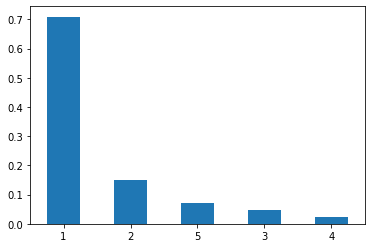

In [31]:
data['passenger_count'].value_counts(normalize = True).plot.bar()
plt.xticks(rotation = 0)

Observation:
- Almost 70% of trips had only 1 passanger

### Day of the week

(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, '4'),
  Text(1, 0, '5'),
  Text(2, 0, '3'),
  Text(3, 0, '2'),
  Text(4, 0, '1'),
  Text(5, 0, '6'),
  Text(6, 0, '0')])

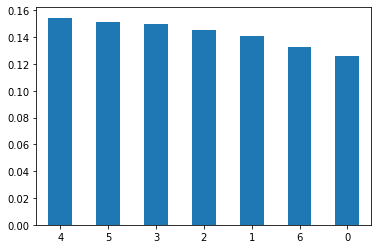

In [32]:
data['day_of_the_week'].value_counts(normalize = True).plot.bar()
plt.xticks(rotation = 0)

Observation:
- As expected, Friday (weekend eve) and Saturday had the highest number of trips

### Pickup Time

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23]),
 [Text(0, 0, '19'),
  Text(1, 0, '18'),
  Text(2, 0, '20'),
  Text(3, 0, '21'),
  Text(4, 0, '22'),
  Text(5, 0, '13'),
  Text(6, 0, '12'),
  Text(7, 0, '23'),
  Text(8, 0, '14'),
  Text(9, 0, '17'),
  Text(10, 0, '15'),
  Text(11, 0, '11'),
  Text(12, 0, '9'),
  Text(13, 0, '8'),
  Text(14, 0, '10'),
  Text(15, 0, '16'),
  Text(16, 0, '0'),
  Text(17, 0, '7'),
  Text(18, 0, '1'),
  Text(19, 0, '2'),
  Text(20, 0, '6'),
  Text(21, 0, '3'),
  Text(22, 0, '4'),
  Text(23, 0, '5')])

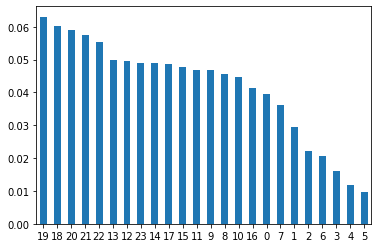

In [33]:
data['pickup_hour'].value_counts(normalize = True).plot.bar()
plt.xticks(rotation = 0)

Observation:
- As expected, the number of trips are low during 1am - 5am, and peak between 7pm - 9pm

We can clearly see that during weekdays, peak hours are during the day while on weekends, peak hours are late in the night

# Bivariate / Multivariate Analysis

In [34]:
import geopandas as gpd

/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


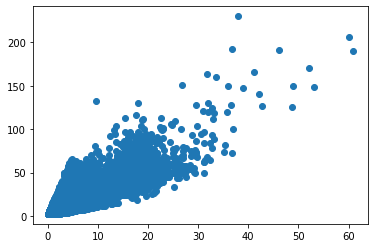

In [35]:
#Scatte plot of distance vs fare amount
plt.scatter(x = data.distance_travelled, y = data.fare_amount)

# Show the plot
plt.show()

Generally, as distance increases, the fare amount also increases with a few sporadic inconsistencies

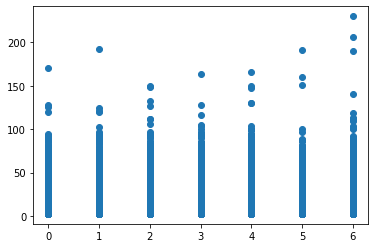

In [36]:
#Scatte plot of day of the week vs fare amount
plt.scatter(x = data.day_of_the_week, y = data.fare_amount)

# Show the plot
plt.show()

Generally speaking, weekend fares are higher than weekday fares. This could be due to distance travelled or due to peak hours

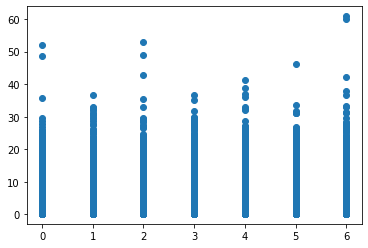

In [37]:
#Scatte plot of day of the week vs distance to see if there is any relationship between them
plt.scatter(x = data.day_of_the_week, y = data.distance_travelled)

# Show the plot
plt.show()

We see that there isn;t much of a relationship between distance travelled vs fay of the week - thus, it is appears that fare amount being higher on weekends has a high likelihood of being linked to peak hours / wait time due to higher traffic.

Unfortunately, we do not have the dropoff time for each ride to be able to ascertain the time of each trip and demonstrate if we can see a relationship between fare and time travelled

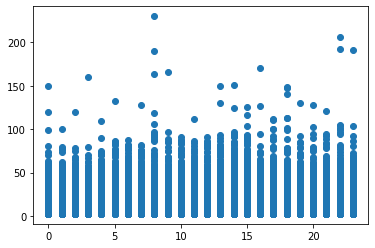

In [38]:
#Scatte plot of pickup time vs fare amount
plt.scatter(x = data.pickup_hour, y = data.fare_amount)

# Show the plot
plt.show()

We do see some pickup times having a greater % of higher fares as compared to others - however, it is difficult to draw a concluding relationship

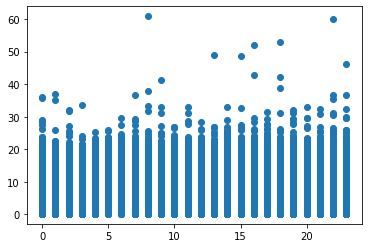

In [39]:
#Scatte plot of pickup time vs distance
plt.scatter(x = data.pickup_hour, y = data.distance_travelled)

# Show the plot
plt.show()

Some pickup hours have a greater concentration of trips where a high distance was travelled as compared to others

### Data Preparatrion

### Feature Scaling

Feature Scaling is required because of two reasons:
1. The data points are far from each other. This means that in some columns, the distance between data points is a lot
2. Some of the features have a unit while other features are unitless. Thereofre, it is important to make all features unitless

In [40]:
#Feature Scaling (Standardization)

from sklearn.preprocessing import StandardScaler

std = StandardScaler()

In [41]:
x = data.drop(['fare_amount'], axis = 1)
y = data['fare_amount'].values.reshape(-1, 1)

In [42]:
y_std = std.fit_transform(y)

x_std = std.fit_transform(x)

In [43]:
x_train, x_test, y_train, y_test = train_test_split(x_std, y_std, test_size = 0.3, random_state = 42)

In [44]:
x_train.shape

(129862, 7)

In [45]:
y_train.shape

(129862, 1)

In [46]:
x_test.shape

(55656, 7)

In [47]:
y_test.shape

(55656, 1)

# Regression Models

## Linear Regression

In [48]:
from sklearn.linear_model import LinearRegression
LR = LinearRegression()
LR.fit(x_train,y_train)

LinearRegression()

In [49]:
LR_pred = LR.predict(x_test)

In [50]:
print("Training set score: {:.2f}".format(LR.score(x_train, y_train)))
print("Test set score: {:.7f}".format(LR.score(x_test, y_test)))

Training set score: 0.89
Test set score: 0.8923059


In [51]:
from sklearn import metrics
from sklearn.metrics import r2_score

MAE_LR= metrics.mean_absolute_error(y_test, LR_pred)
MSE_LR= metrics.mean_squared_error(y_test, LR_pred)
RMSE_LR= np.sqrt(metrics.mean_squared_error(y_test, LR_pred))
r2_LR=r2_score(y_test, LR_pred)
Adj_r2_LR=1-(1-r2_score(y_test, LR_pred))*((len(x_test)-1)/(len(x_test)-len(x_test[0])-1))

In [52]:
print('Mean absolute error of linear regression',MAE_LR)
print('Mean square  error of linear regression',MSE_LR)
print('root Mean square error of linear regression',RMSE_LR)
print('r2 score of linear regression',r2_LR)
print('adjusted r2 of linear regression',Adj_r2_LR)

Mean absolute error of linear regression 0.18255933458542203
Mean square  error of linear regression 0.10839175165648914
root Mean square error of linear regression 0.32922902614515803
r2 score of linear regression 0.8923059388097574
adjusted r2 of linear regression 0.8922923919001051


### Decision Tree Regressor

In [53]:
from sklearn.tree import DecisionTreeRegressor

DT = DecisionTreeRegressor()
DT.fit(x_train, y_train)

DecisionTreeRegressor()

In [54]:
DTpreds = DT.predict(x_test)

In [55]:
print("Training set score: {:.2f}".format(DT.score(x_train, y_train)))
print("Test set score: {:.7f}".format(DT.score(x_test, y_test)))

Training set score: 1.00
Test set score: 0.9905335


In [56]:
MAE_DT= metrics.mean_absolute_error(y_test, DTpreds)
MSE_DT= metrics.mean_squared_error(y_test, DTpreds)
RMSE_DT= np.sqrt(metrics.mean_squared_error(y_test, DTpreds))
r2_DT=r2_score(y_test, DTpreds)
Adj_r2_DT=1-(1-r2_score(y_test, DTpreds))*((len(x_test)-1)/(len(x_test)-len(x_test[0])-1))

In [57]:
print('Mean absolute error of decision tree',MAE_DT)
print('Mean square  error of decision tree',MSE_DT)
print('root Mean square error of decision tree',RMSE_DT)
print('r2 score of decision tree',r2_DT)
print('adjusted r2 of decision tree',Adj_r2_DT)

Mean absolute error of decision tree 0.006680759275284765
Mean square  error of decision tree 0.009527822723673947
root Mean square error of decision tree 0.09761056665993671
r2 score of decision tree 0.9905335054768284
adjusted r2 of decision tree 0.9905323146800044


### Random Forest regressor

In [58]:
from sklearn.ensemble import RandomForestRegressor

RF = RandomForestRegressor()
RF.fit(x_train, y_train)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


RandomForestRegressor()

In [59]:
RFpreds = RF.predict(x_test)

In [60]:
print("Training set score: {:.2f}".format(RF.score(x_train, y_train)))
print("Test set score: {:.7f}".format(RF.score(x_test, y_test)))

Training set score: 1.00
Test set score: 0.9979966


In [61]:
MAE_RF= metrics.mean_absolute_error(y_test, RFpreds)
MSE_RF= metrics.mean_squared_error(y_test, RFpreds)
RMSE_RF= np.sqrt(metrics.mean_squared_error(y_test, RFpreds))
r2_RF=r2_score(y_test, RFpreds)
Adj_r2_RF=1-(1-r2_score(y_test, RFpreds))*((len(x_test)-1)/(len(x_test)-len(x_test[0])-1))

In [62]:
print('Mean absolute error of random forest',MAE_RF)
print('Mean square  error of random forest',MSE_RF)
print('root Mean square error of random forest',RMSE_RF)
print('r2 score of random forest',r2_RF)
print('adjusted r2 of random forest',Adj_r2_RF)

Mean absolute error of random forest 0.00328362949829837
Mean square  error of random forest 0.0020163551993890704
root Mean square error of random forest 0.04490384392665143
r2 score of random forest 0.9979966235723134
adjusted r2 of random forest 0.9979963715662217


# Boosting

In [63]:
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor

## Gradient Boosting

In [64]:
gbr = GradientBoostingRegressor(random_state = 42)
gbr.fit(x_train, y_train)
predictions_gbr = gbr.predict(x_test)

/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [65]:
print("Training set score: {:.2f}".format(gbr.score(x_train, y_train)))
print("Test set score: {:.7f}".format(gbr.score(x_test, y_test)))

Training set score: 1.00
Test set score: 0.9966091


In [66]:
MAE_GBR= metrics.mean_absolute_error(y_test, predictions_gbr)
MSE_GBR= metrics.mean_squared_error(y_test, predictions_gbr)
RMSE_GBR= np.sqrt(metrics.mean_squared_error(y_test, predictions_gbr))
r2_GBR=r2_score(y_test, predictions_gbr)
Adj_r2_GBR=1-(1-r2_score(y_test, predictions_gbr))*((len(x_test)-1)/(len(x_test)-len(x_test[0])-1))

In [67]:
print('Mean absolute error of gradient boosting regressor',MAE_GBR)
print('Mean square  error of gradient boosting regressor',MSE_GBR)
print('root Mean square error of gradient boosting regressor',RMSE_GBR)
print('r2 score of gradient boosting regressor',r2_GBR)
print('adjusted r2 of gradient boosting regressor',Adj_r2_GBR)

Mean absolute error of gradient boosting regressor 0.029872330420472305
Mean square  error of gradient boosting regressor 0.0034129008779245898
root Mean square error of gradient boosting regressor 0.05842003832525779
r2 score of gradient boosting regressor 0.9966090671073545
adjusted r2 of gradient boosting regressor 0.9966086405595855


## XGBoost Classifier

In [68]:
from xgboost import XGBRegressor

In [69]:
xgb = XGBRegressor(random_state = 42, scale_pos_weight = 1)
xgb.fit(x_train, y_train)
predictions_xgb = xgb.predict(x_test)

In [70]:
print("Training set score: {:.2f}".format(xgb.score(x_train, y_train)))
print("Test set score: {:.7f}".format(xgb.score(x_test, y_test)))

Training set score: 1.00
Test set score: 0.9978147


In [71]:
MAE_XGB= metrics.mean_absolute_error(y_test, predictions_xgb)
MSE_XGB= metrics.mean_squared_error(y_test, predictions_xgb)
RMSE_XGB= np.sqrt(metrics.mean_squared_error(y_test, predictions_xgb))
r2_XGB=r2_score(y_test, predictions_xgb)
Adj_r2_XGB=1-(1-r2_score(y_test, predictions_xgb))*((len(x_test)-1)/(len(x_test)-len(x_test[0])-1))

In [72]:
print('Mean absolute error of XGB regressor',MAE_XGB)
print('Mean square  error of XGB regressor',MSE_XGB)
print('root Mean square error of XGB regressor',RMSE_XGB)
print('r2 score of XGB regressor',r2_XGB)
print('adjusted r2 of XGB regressor',Adj_r2_XGB)

Mean absolute error of XGB regressor 0.014764769122896143
Mean square  error of XGB regressor 0.0021994386528932834
root Mean square error of XGB regressor 0.04689817323620701
r2 score of XGB regressor 0.99781471858099
adjusted r2 of XGB regressor 0.9978144436929449


# Choosing the best models

In [73]:
cols = ['Model', 'MSE', 'RMSE', 'R2_score','MAE','ADJ_r']

# create a empty dataframe of the colums
result_table = pd.DataFrame(columns = cols)

In [74]:
full_metrics = pd.Series({'Model': "Linear Regression", 'MSE': MSE_LR, 'RMSE' : RMSE_LR, 'R2_score' : r2_LR,'MAE':MAE_LR,'ADJ_r':Adj_r2_LR})

In [75]:
result_table = result_table.append(full_metrics, ignore_index = True)

In [76]:
full_metrics = pd.Series({'Model': "Decision Tree", 'MSE': MSE_DT, 'RMSE' : RMSE_DT, 'R2_score' : r2_DT,'MAE':MAE_DT,'ADJ_r':Adj_r2_DT})

In [77]:
result_table = result_table.append(full_metrics, ignore_index = True)

In [78]:
full_metrics = pd.Series({'Model': "Random Forest", 'MSE': MSE_RF, 'RMSE' : RMSE_RF, 'R2_score' : r2_RF,'MAE':MAE_RF,'ADJ_r':Adj_r2_RF})

In [79]:
result_table = result_table.append(full_metrics, ignore_index = True)

In [80]:
full_metrics = pd.Series({'Model': "Gardient Boosting", 'MSE': MSE_GBR, 'RMSE' : RMSE_GBR, 'R2_score' : r2_GBR,'MAE':MAE_GBR,'ADJ_r':Adj_r2_GBR})

In [81]:
result_table = result_table.append(full_metrics, ignore_index = True)

In [82]:
full_metrics = pd.Series({'Model': "XGBoost", 'MSE': MSE_XGB, 'RMSE' : RMSE_XGB, 'R2_score' : r2_XGB,'MAE':MAE_XGB,'ADJ_r':Adj_r2_XGB})

In [83]:
result_table = result_table.append(full_metrics, ignore_index = True)

In [84]:
result_table

,Model,MSE,RMSE,R2_score,MAE,ADJ_r
0,Linear Regression,0.108392,0.329229,0.892306,0.182559,0.892292
1,Decision Tree,0.009528,0.097611,0.990534,0.006681,0.990532
2,Random Forest,0.002016,0.044904,0.997997,0.003284,0.997996
3,Gardient Boosting,0.003413,0.058420,0.996609,0.029872,0.996609
4,XGBoost,0.002199,0.046898,0.997815,0.014765,0.997814


Based on the above, Random Forest produces the best results out of all tested models. However, hyperparameter tuning could help improve the results